<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/EAI6010_PranayBindela_Week2_Term_1_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Image Style transfer is a concept where we inject a artistic style on to a image and make it look like, its actually was drawn by the actual artist itself. Consider an image, a normal photo or potrait and the goal in hand is to inject a particular style on it. It can be done is various ways and one of which is discussed in this paper, where there a content image C, stylezed image s and we have to generate a stylezed content image X

# Analysis

To generate a stylized content image, we need to figure out a way to find the difference in style by keeping the original shape intact. At the core, we need to figure out a loss function which is combination of style loss and shape loss. 

To find out loss in dimensions or shapes, we can use Eucledian distance loss function like MSE Loss or RMSE loss between black and white version of  original and stylized image, find the Eucledian loss. Coming to the second problem, where we have to find the loss of style, this Eucledian loss does not fit the problem. We need to have something which is good in differentiating the style alone, but not the dimensions and shapes, for this we make use of Feature Loss function or Perceptual Loss function as shown in the below diagram


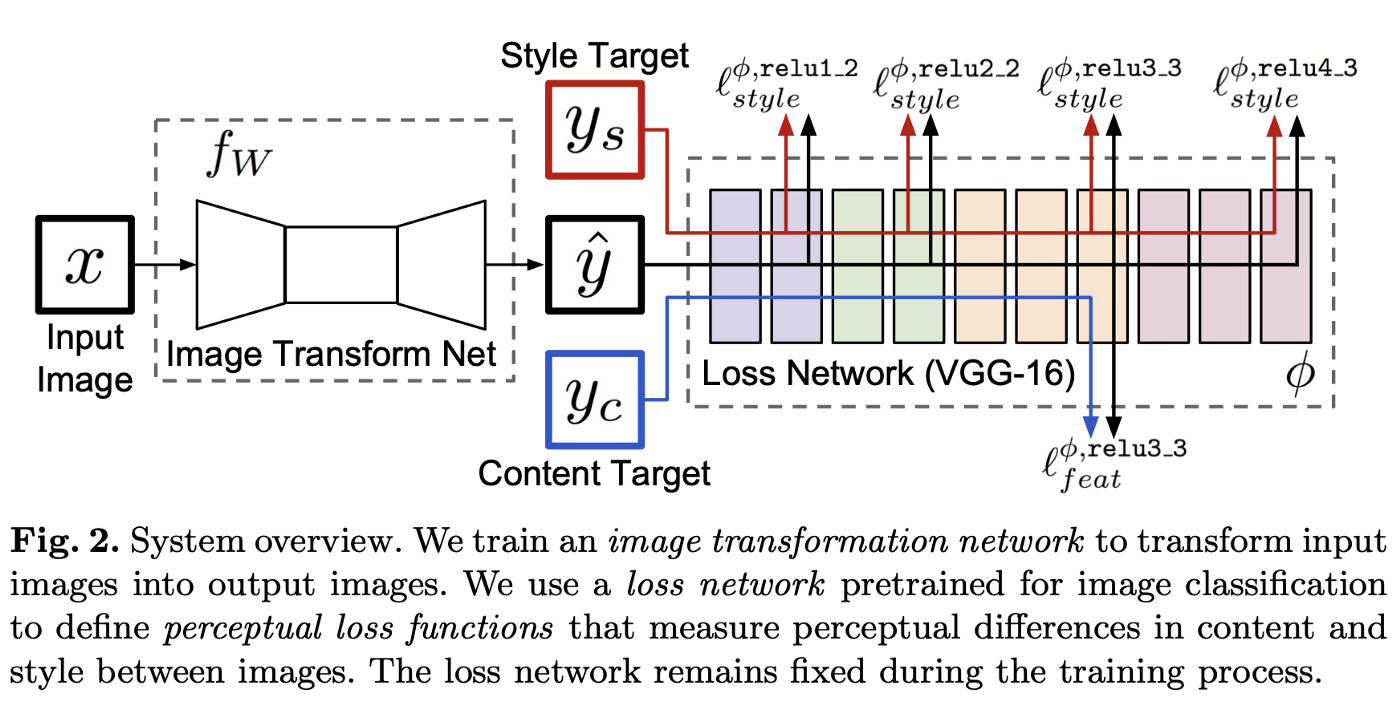

Lets now look at how it is implemented in code using tensorflow

## Setup



In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.8.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  False


## Pre-Processing functions

***crop_center***: This function takes in a image matrix with shape x\*y\*z which is not a square, and returns a cropped image of square shape with dimensions x\*t\*t

***load_image***: This function's job is to load image and crop it with given dimensions. It takes 3. aarguments, image_url, desired image size and a boolean argument of preserve_aspect_ratio. The final argumet is used to preserve the original aspect ratio after cropping. 

***show_n***: This function is used to show multiple images. 

***load_local_image***: This functions takes in the raw image as input and returns tensor format of image, which is further used for processing with tensorflow. 


In [2]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

def load_local_image(image_bytes, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
   # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = image_bytes
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

## Loading TF-Hub Module

In [3]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

### Lets load content and style image and preprocess them - Lets use original files.

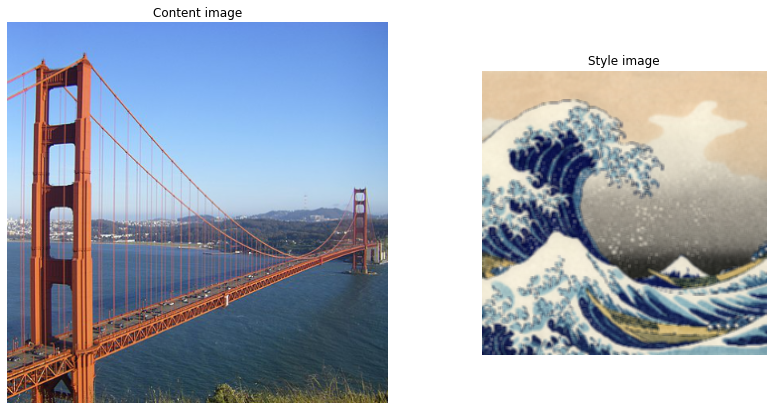

In [5]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Image Stylazation. 

We need to use hub_module function which we have loaded earlier. This function takes in content image and a stylized image and returns a stylized content image.

All the computation in Tenssorflow happens in batches and we have single images, so we have to convert them into batches of one and pass it to the function. Even the output will also be a batched one. 


In [6]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

### Results

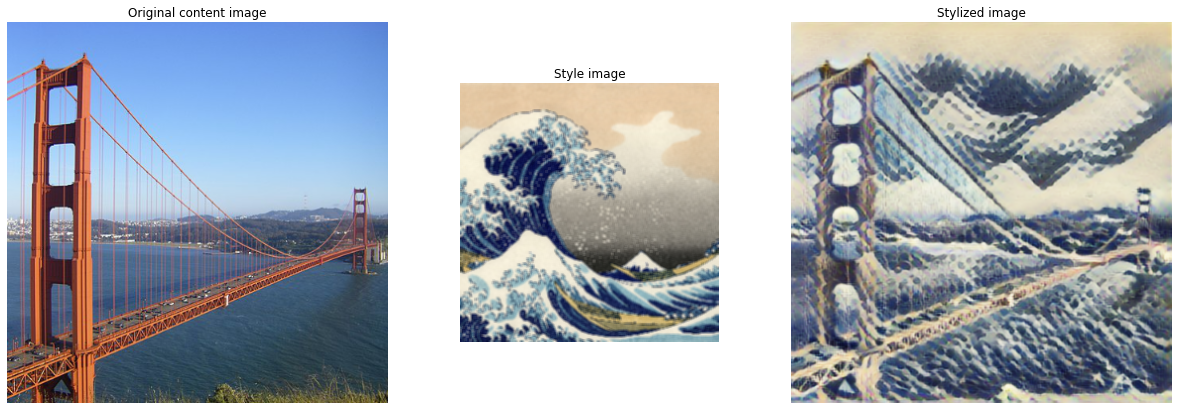

In [7]:
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

### With Northeastern Logo

Browse to the style file  to be uploaded


Saving NortheasternLogo_256x256.jpeg to NortheasternLogo_256x256.jpeg
User uploaded file NortheasternLogo_256x256.jpeg with length 24546 fbytes
Browse to the content file to be uploaded


Saving 20220319_150837_042.jpg to 20220319_150837_042.jpg
User uploaded content file 20220319_150837_042.jpg with length 5582857 fbytes


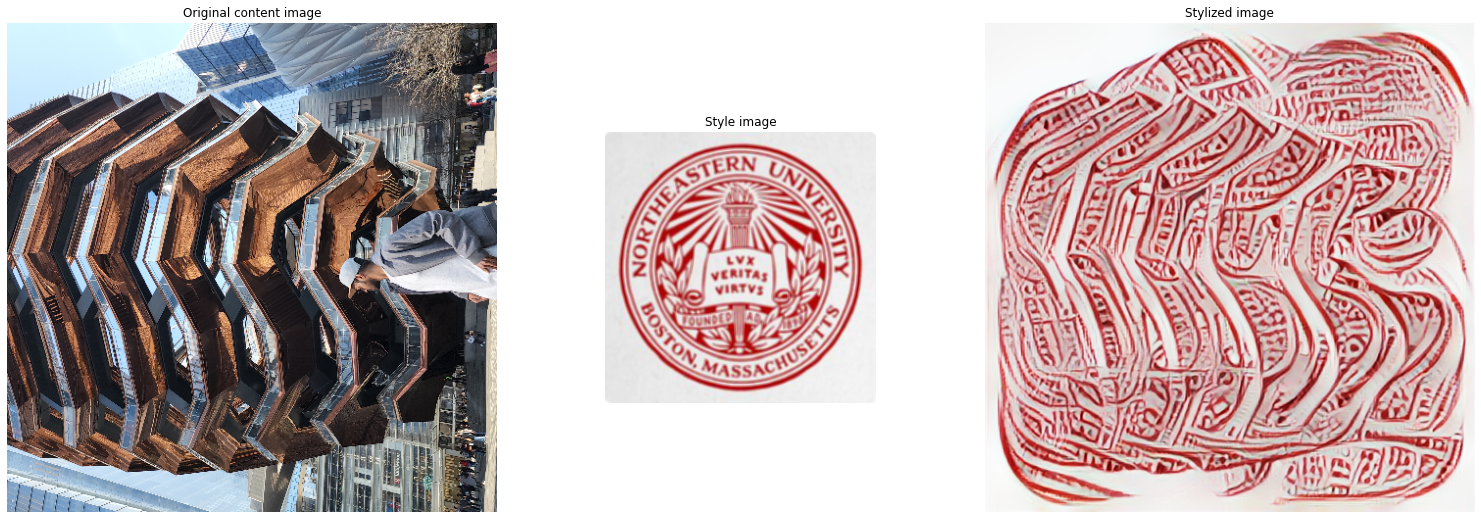

In [11]:
from google.colab import files
# load style image from the local filesystem
print("Browse to the style file  to be uploaded") 
style_uploaded = files.upload()
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn, 
                                                      length=len(style_uploaded[fn])))
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# @title Load example images  { display-mode: "form" }
output_image_size = 500  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

### Experiments with different images

Browse to the content file to be uploaded


Saving 20220319_193648_028.jpg to 20220319_193648_028 (2).jpg
User uploaded content file 20220319_193648_028.jpg with length 4895430 fbytes


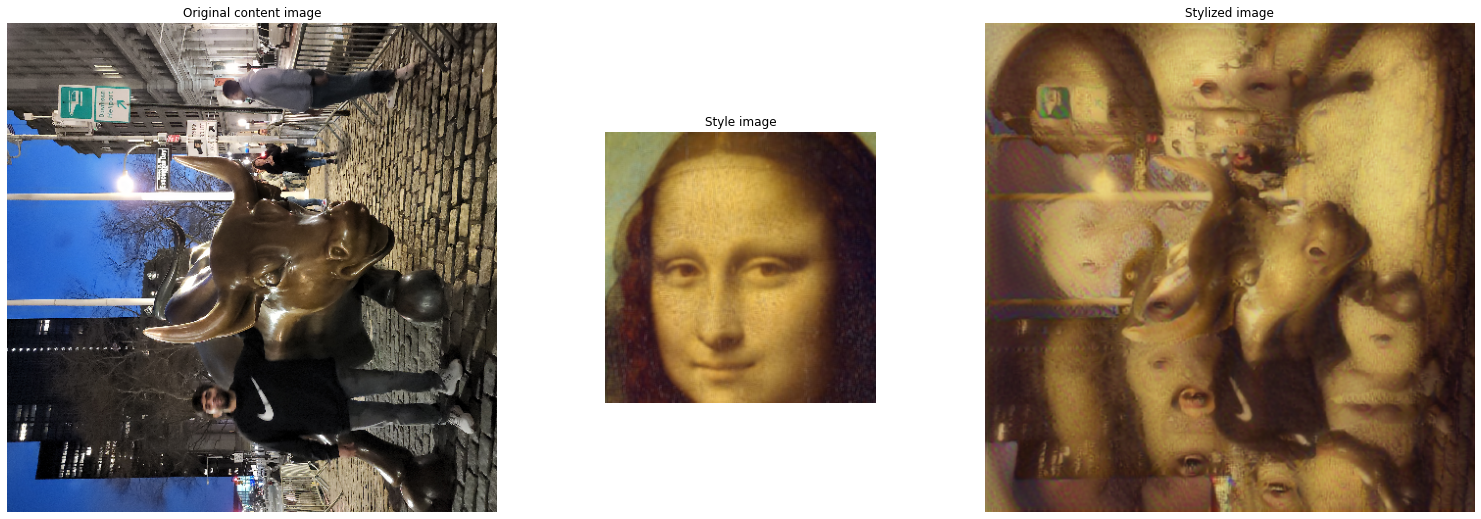

In [12]:
from google.colab import files

#getting the style image

style_image_url = 'https://ychef.files.bbci.co.uk/976x549/p096q1j7.jpg'  # @param {type:"string"} - Monalisa Image
style_img_size = (256, 256)  # Recommended to keep it at 256.
style_image = load_image(style_image_url, style_img_size)


# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]
output_image_size = 500  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).

#preprocessing content image
content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

# Conclusion

This is one way of implementing image style transfer, there are lot of apps in the sstore which does the same stuff like Prisma. 

I have implemented one version of Image Style transfer with custom created Loss function which is implemented here 

https://github.com/pranay8297/deep-learning-projects/blob/master/prisma_own.ipynb


## References

[1] Ghiasi, G., Lee, H., Kudlur, M., Dumoulin, V., & Shlens, J. (2017). Exploring the structure of a real-time, arbitrary neural artistic stylization network. ArXiv:1705.06830 [Cs]. https://arxiv.org/abs/1705.06830

[2] Mikhailiuk, A. (2021, May 10). Perceptual Losses for Deep Image Restoration. Medium. https://towardsdatascience.com/perceptual-losses-for-image-restoration-dd3c9de4113